In [1]:
pip install --upgrade gtfs-realtime-bindings


  Preparing metadata (setup.py) ... done
  Created wheel for gtfs-realtime-bindings: filename=gtfs_realtime_bindings-1.0.0-py3-none-any.whl size=5988 sha256=d876c1bb75348837babe54b88377e9de53eac68b9ba19d87b55681bdacec60f1
  Stored in directory: /root/.cache/pip/wheels/43/98/27/68e4d1de8bb9d8505cfe412bf9af51e66f3e3bd2c98c849c3f
Successfully built gtfs-realtime-bindings


In [2]:
from google.colab import drive
drive.mount('/content/drive')

from google.transit import gtfs_realtime_pb2
import requests
import time
from datetime import datetime, timezone, timedelta
import os
import pandas as pd
import numpy as np
#from protobuf_to_dict import protobuf_to_dict
import sqlite3
import csv
import matplotlib.pyplot as plt
#Following 2 lines added for Google Colab
base_dir = '/content/drive/My Drive/Real_Time_LIRR/'
os.chdir(base_dir)

def db_setup():
    con = sqlite3.connect("lirr_gtfs.db")
    cur = con.cursor()

    # Drop tables
    cur.execute('DROP TABLE IF EXISTS agency')
    cur.execute('DROP TABLE IF EXISTS calendar_dates')
    cur.execute('DROP TABLE IF EXISTS feed_info')
    cur.execute('DROP TABLE IF EXISTS routes')
    cur.execute('DROP TABLE IF EXISTS shapes')
    cur.execute('DROP TABLE IF EXISTS stop_times')
    cur.execute('DROP TABLE IF EXISTS stops')
    cur.execute('DROP TABLE IF EXISTS transfers')
    cur.execute('DROP TABLE IF EXISTS trips')
    #crete table
    cur.execute('''CREATE TABLE IF NOT EXISTS agency (
                        agency_id TEXT PRIMARY KEY,
                        agency_name TEXT,
                        agency_url TEXT,
                        agency_timezone TEXT,
                        agency_lang TEXT,
                        agency_phone TEXT)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS calendar_dates (
                        service_id TEXT,
                        date TEXT,
                        exception_type INTEGER,
                        PRIMARY KEY (service_id, date))''')

    cur.execute('''CREATE TABLE IF NOT EXISTS feed_info (
                        feed_publisher_name TEXT,
                        feed_publisher_url TEXT,
                        feed_timezone TEXT,
                        feed_lang TEXT,
                        feed_version TEXT)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS routes (
                        route_id TEXT PRIMARY KEY,
                        route_long_name TEXT,
                        route_type INTEGER,
                        route_color TEXT,
                        route_text_color TEXT)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS shapes (
                        shape_id TEXT,
                        shape_pt_lat REAL,
                        shape_pt_lon REAL,
                        shape_pt_sequence INTEGER)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS stop_times (
                        trip_id TEXT,
                        arrival_time TEXT,
                        departure_time TEXT,
                        stop_id TEXT,
                        stop_sequence INTEGER,
                        pickup_type INTEGER,
                        drop_off_type INTEGER)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS stops (
                        stop_id TEXT PRIMARY KEY,
                        stop_code TEXT,
                        stop_name TEXT,
                        stop_lat REAL,
                        stop_lon REAL,
                        stop_url TEXT,
                        wheelchair_boarding INTEGER)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS transfers (
                        from_stop_id TEXT,
                        to_stop_id TEXT,
                        from_trip_id TEXT,
                        to_trip_id TEXT,
                        transfer_type INTEGER,
                        min_transfer_time INTEGER)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS trips (
                        route_id TEXT,
                        service_id TEXT,
                        trip_id TEXT PRIMARY KEY,
                        trip_headsign TEXT,
                        trip_short_name TEXT,
                        direction_id INTEGER,
                        shape_id TEXT,
                        peak_offpeak INTEGER)''')

    file_list = {
        'agency': 'google_transit/agency.txt',
        'calendar_dates': 'google_transit/calendar_dates.txt',
        'feed_info': 'google_transit/feed_info.txt',
        'routes': 'google_transit/routes.txt',
        'shapes': 'google_transit/shapes.txt',
        'stop_times': 'google_transit/stop_times.txt',
        'stops': 'google_transit/stops.txt',
        'transfers': 'google_transit/transfers.txt',
        'trips': 'google_transit/trips.txt'
    }


    for table_name, file_path in file_list.items():
        with open(file_path, 'r') as file:
            reader = csv.reader(file, delimiter=',')
            headers = next(reader)
            placeholders = ','.join(['?'] * len(headers))
            query = f'INSERT OR IGNORE INTO {table_name} ({",".join(headers)}) VALUES ({placeholders})'
            for row in reader:
                try:
                    cur.execute(query, row)
                except sqlite3.IntegrityError as e:
                    print(f"Error inserting row into {table_name}: {row}")
                    print(e)

    con.commit()
    con.close()

def import_txt_as_list(path):
    lists = {}
    for file_name in os.listdir(path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(path, file_name)
            with open(file_path, 'r') as file:
                lists[file_name] = [line.strip() for line in file]
    return lists
csv_path_const = '/content/drive/My Drive/Real_Time_LIRR/data/' #With google drive
#csv_path_const = 'data/gtfs_data_collection.csv' #original

Mounted at /content/drive


Defines what is considered a delay in terms of seconds. The official LIRR Delay metric is when each train reaches its terminal more than 5 min 59 seconds late, however because transfers can be as tight as 5 minutes long my metric is when each train passes this station later than 60 seconds of its scheduled time.

In [3]:
DELAY = 60

In [4]:
def analyze():
    return 0


def print_all_tables():
    con = sqlite3.connect("lirr_gtfs.db")
    cur = con.cursor()
    tables = ['agency', 'calendar_dates', 'feed_info', 'routes', 'shapes', 'stop_times', 'stops', 'transfers', 'trips']

    for table in tables:
        cur.execute(f'SELECT * FROM {table}')
        rows = cur.fetchall()
        print(f'Table: {table}')
        for row in rows:
            print(row)
        print('\n')

    con.close()

In [58]:
def get_info_trip(cur, train):
    trip_id = train['trip_id']
    trip = cur.execute(f'SELECT * FROM trips WHERE trip_id = ?', (trip_id,)).fetchone()
    route = trip[0]
    service_id = trip[1]
    trip_id = trip[2]
    trip_headsign = trip[3]
    trip_short_name = trip[4]
    direction_id = trip[5]
    shape_id = trip[6] #not used
    peak_offpeak = trip[7]
    terminal_info = [route, service_id, trip_headsign, trip_short_name, direction_id, peak_offpeak]
    return terminal_info


#given a file path, combine every file inside the list into a single pandas dataframe
def combine_all_csv(file_path):

    #list all the files from the directory
    file_list = os.listdir(file_path)
    #print(file_list)
    combined_list = []
    for file in file_list:
        file_str = file_path + '/' + file
        csv_data = read_csv(file_str)

        combined_list.append(csv_data)
        #df = pd.read_csv(file_str)
        #df_combined = df_combined.append(df, ignore_index=True)
    #file_list
    #df_combined = pd.DataFrame(combined_list)
    df_combined = pd.concat([pd.DataFrame(lst) for lst in combined_list], ignore_index=True) #Concatenate the list of DataFrames into a single DataFrame
    return df_combined


#probably redundant
def read_csv(csv_path):
    data = []
    with open(csv_path, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)
    return data

def find_train_csv(panda_df, train_id):
    train_data = panda_df[panda_df['train_id'] == train_id]
    #if failed
    if(train_data.empty):
        return None
    return train_data

def find_arrival_time(train_data):
    return train_data['local_arrival_time']

def convert_to_seconds(delay_str):
    parts = delay_str.split()
    minutes = int(parts[0]) if parts[1] == 'm' else 0
    seconds = int(parts[2]) if parts[3] == 's' else 0
    total_seconds = minutes * 60 + seconds
    return total_seconds if delay_str[0] != '-' else -total_seconds

#Given a delay string, convert it to a number representing seconds
def parse_delay(delay):

    sign = 1
    if delay.startswith('-'):
        sign = -1
        delay = delay[1:]

    parts = delay.split(' ')
    minutes = int(parts[0].replace('m', ''))
    seconds = int(parts[1].replace('s', ''))
    total_seconds = minutes * 60 + seconds
    if(sign == -1):
        total_seconds = total_seconds * -1
    return total_seconds


#Given OPTION = -1, remove delays <-15 min or >15 min (Excessive delays)
def clean_data_drop_outliers(data_frame, option):
    data_frame_new = data_frame.copy()
    # Remove duplicate rows this does not work
    #data_frame_new = data_frame_new.drop_duplicates()

    # If option is -1, remove rows with excessive delays
    if option == -1:
        indices_to_drop = []
        for index, row in data_frame_new.iterrows():
            delay_converted_s = parse_delay(row['delay_formatted'])
            if delay_converted_s > (15 * 60) or delay_converted_s < (-15 * 60):
                indices_to_drop.append(index)

        data_frame_new = data_frame_new.drop(indices_to_drop)


    data_frame_new['delay_formatted'] = data_frame_new['delay_formatted'].apply(parse_delay)
    return data_frame_new

#return number of trains aka length of dataframe
def count_trains(pandas_df):
    return len(pandas_df)

#counts the number of trains on a particular route
#Routes/Branches: Babylon, Hempstead, Oyster Bay, Ronkonkoma, Montauk, Long Beach, Far Rockaway, West Hempstead, Port Washington, Port Jefferson, Belmont Park, City Terminal
def count_routes(pandas_df):
    route_counter =  [0,0,0,0,0,0,0,0,0,0,0,0]
    for index, train in pandas_df.iterrows():
        route_id = train['route_id']

        route_counter[int(route_id)-1] = route_counter[int(route_id)-1] + 1

    return route_counter

#count number of trains on each route that arrive 0 min or later
def delayed_trains_per_route(pandas_df):
    route_counter =  [0,0,0,0,0,0,0,0,0,0,0,0]
    for index, train in pandas_df.iterrows():
        route_id = train['route_id']
        #delay = train['delay_formatted']
        delay_seconds = train['delay_formatted']
        #delay_formatted = delay.time()
        #delay_seconds = parse_delay(delay_formatted)
        if(delay_seconds>DELAY):

          route_id = train['route_id']
          route_counter[int(route_id)-1] = route_counter[int(route_id)-1] + 1
    return route_counter

#categorize the severity of delays that happen (negative delay = on time)
def category_of_delays(pandas_df):
    categories = [-float('inf'), -600, -300, -120, 0, 120, 300, 600, float('inf')]
    labels = ['> -10 min', '(-10 to -5 min]', '(-5 to -2 min]', '(-2-0 min]', '(0-2 min]', '(2-5 min]', '(5-10 min]', '>10+ min']
    count_df = pandas_df.copy()

    count_df['category'] = pd.cut(count_df['delay_formatted'], bins=categories, labels=labels)
    category_counts = count_df['category'].value_counts().reindex(labels, fill_value=0)
    #print(category_counts)
    return count_df,category_counts
#sorts trains per hour
def delayed_trains_per_hour(pandas_df):
    count_df = pandas_df.copy()
    count_df['local_arrival_time'] = pd.to_datetime(count_df['local_arrival_time'], utc=True)
    #count_df['local_arrival_time'] = pd.to_datetime(count_df['local_arrival_time'], format='%Y-%m-%d %H:%M:%S')
    #count_df['local_arrival_time'] = pd.to_datetime(count_df['local_arrival_time'], errors='coerce').dt.tz_localize(None)



    count_df['hour'] = pd.to_datetime(count_df['local_arrival_time']).dt.strftime('%H')

    delayed_trains_df = count_df[count_df['delay_formatted'] > DELAY]
    delayed_trains_count = delayed_trains_df.groupby('hour').size().reset_index(name='delayed_trains_count')
    total_trains_count = count_df.groupby('hour').size().reset_index(name='total_trains_count')

    all_hours = pd.DataFrame({'hour': [f'{i:02d}' for i in range(24)]})

    merged_counts = pd.merge(all_hours, delayed_trains_count, on='hour', how='left')
    merged_counts = pd.merge(merged_counts, total_trains_count, on='hour', how='left')

    merged_counts['delayed_trains_count'] = merged_counts['delayed_trains_count'].fillna(0).astype(int)
    merged_counts['total_trains_count'] = merged_counts['total_trains_count'].fillna(0).astype(int)

    merged_counts['percentage_delayed'] = (
        (merged_counts['delayed_trains_count'] / merged_counts['total_trains_count']) * 100
        ).fillna(0)

    return merged_counts





In [6]:
#Get all transfers of a particualr trip at station station_id
def get_transfers_trip(cur, station_id, trip_id):
    #transfers = cur.execute(f'SELECT ALL FROM transfers WHERE from_stop_id = ?',(station_id)).fechall()
    query = '''
    SELECT *
    FROM transfers
    WHERE from_stop_id = ?
    AND (from_trip_id = ? OR to_trip_id = ?)
    '''
    cur.execute(query, (station_id, trip_id, trip_id))
    transfers = cur.fetchall()
    return transfers

def convert_to_seconds (time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    # Calculate the total number of seconds
    seconds = hours * 3600 + minutes * 60 + seconds

    return seconds
#Method to find how many transfers were "missed". This assumes a 3 min buffer period for all transfers.
#Trains with <3 min buffer period
#Obtains all transfer times via analyzing stop_times.txt
#Returns number of transfers where transfer time is in the negatives


def analyze_transfers_trip_act(cur, transfers, station_id, expected_val, df):
    missed_transfers = 0
    unknown_transfers = 0


    for transfer in transfers:
        from_stop_id, to_stop_id, from_trip_id, to_trip_id, transfer_id, _ = transfer


        transfer_found = False
        transfer_time = None


        if expected_val == 1:

            transfer_row_from = df[df['trip_id'] == from_trip_id]
            if not transfer_row_from.empty:
                transfer_found = True
                transfer_time = pd.to_datetime(transfer_row_from['local_arrival_time'].iloc[0])
        else:
            transfer_row_to = df[df['trip_id'] == to_trip_id]
            if not transfer_row_to.empty:
                transfer_found = True
                transfer_time = pd.to_datetime(transfer_row_to['local_arrival_time'].iloc[0])

        if not transfer_found:
            unknown_transfers += 1
            continue


        query = '''
        SELECT arrival_time, departure_time
        FROM stop_times
        WHERE trip_id = ? AND stop_id = ?
        '''


        cur.execute(query, (from_trip_id, station_id))
        stop_times_from = cur.fetchall()


        cur.execute(query, (to_trip_id, station_id))
        stop_times_to = cur.fetchall()


        if not stop_times_from and not stop_times_to:
            unknown_transfers += 1
            continue


        transfer_time = transfer_time.tz_localize(None)
        buffer = timedelta(minutes=3)

        missed_in_from = missed_in_to = False


        if stop_times_from:
            arrival_time_str, _ = stop_times_from[0]
            arrival_time_from = pd.to_datetime(arrival_time_str).tz_localize(None)
            if expected_val == 1 and transfer_time - arrival_time_from < buffer:
                missed_in_from = True
            elif expected_val != 1 and transfer_time - arrival_time_from < buffer:
                missed_in_from = True


        if stop_times_to:
            arrival_time_str, _ = stop_times_to[0]
            arrival_time_to = pd.to_datetime(arrival_time_str).tz_localize(None)
            if expected_val == 1 and transfer_time - arrival_time_to < buffer:
                missed_in_to = True
            elif expected_val != 1 and transfer_time - arrival_time_to < buffer:
                missed_in_to = True


        if missed_in_from or missed_in_to:
            missed_transfers += 1

    return missed_transfers, unknown_transfers


In [7]:


def time_to_seconds(t):
    """Convert a time object to the number of seconds since midnight."""
    return t.hour * 3600 + t.minute * 60 + t.second

def analyze_transfers_trip(cur, station_id, df):
    missed_transfer_count = 0


    for index, row in df.iterrows():
        trip_id = row['trip_id']
        arrival_time_str = row['local_arrival_time']


        arrival_time_str = arrival_time_str[:19]
        arrival_time = datetime.strptime(arrival_time_str, "%Y-%m-%d %H:%M:%S").time()


        cur.execute('''
            SELECT from_stop_id, to_stop_id, from_trip_id, to_trip_id, transfer_type, min_transfer_time
            FROM transfers
            WHERE (from_trip_id = ? OR to_trip_id = ?)
            AND (from_stop_id = ? OR to_stop_id = ?)
        ''', (trip_id, trip_id, station_id, station_id))

        transfers = cur.fetchall()


        for transfer in transfers:

            from_stop_id, to_stop_id, from_trip_id, to_trip_id, transfer_type, min_transfer_time = transfer


            if trip_id == from_trip_id:
                paired_trip_id = to_trip_id
            elif trip_id == to_trip_id:
                paired_trip_id = from_trip_id
            else:
                continue


            cur.execute('''
                SELECT departure_time
                FROM stop_times
                WHERE trip_id = ? AND stop_id = ?
                ORDER BY stop_sequence
                LIMIT 1
            ''', (paired_trip_id, station_id))

            paired_departure_time_row = cur.fetchone()

            if paired_departure_time_row:

                paired_departure_time_str = paired_departure_time_row[0]
                paired_departure_time = datetime.strptime(paired_departure_time_str, "%H:%M:%S").time()


                arrival_seconds = time_to_seconds(arrival_time)
                paired_departure_seconds = time_to_seconds(paired_departure_time)


                if (paired_departure_seconds <= arrival_seconds) or (abs(paired_departure_seconds - arrival_seconds) <= 180):
                    missed_transfer_count += 1

    return missed_transfer_count



In [8]:
def count_delayed_trains_info(pandas_df):

    count_df = pandas_df.copy()

    for idx, row in count_df.iterrows():
        trip_id = row['trip_id']
        query = """
            SELECT peak_offpeak
            FROM trips
            WHERE trip_id = ?
        """
        result = cur.execute(query, (trip_id,)).fetchone()

        if result:
            count_df.at[idx, 'peak_offpeak'] = result[0]
        else:
            count_df.at[idx, 'peak_offpeak'] = 3
    am_peak_count = count_df[(count_df['direction_id'].astype(int) == 1) & (count_df['peak_offpeak'].astype(int) == 1)].shape[0]
    pm_peak_count = count_df[(count_df['direction_id'].astype(int) == 0) & (count_df['peak_offpeak'].astype(int) == 1)].shape[0]

    peak_count = count_df[count_df['peak_offpeak'].astype(int) == 1].shape[0]
    off_peak_count = count_df[count_df['peak_offpeak'].astype(int) == 0].shape[0]
    unknown_count = count_df[count_df['peak_offpeak'].astype(int) == 3].shape[0]
    print(f"AM Peak count: {am_peak_count}")
    print(f"PM Peak count: {pm_peak_count}")
    print(f"Peak count: {peak_count}")
    print(f"Off Peak count: {off_peak_count}")
    print(f"Unknown count: {unknown_count}")
    print(f"Total count: {len(pandas_df)}")
    result = {
        'AM Peak': am_peak_count,
        'PM Peak': pm_peak_count,
        'Peak': peak_count,
        'Off Peak': off_peak_count,
        'Unknown': unknown_count
    }
    return count_df, result


In [9]:
def get_delay_numeric_percentage(pandas_df):
  tot_trains = len(pandas_df)
  delayed_trains_info = pandas_df[pandas_df['delay_formatted'] > DELAY]

  print("Num trains delayed:")
  print(len(delayed_trains_info))
  print("Percentage of trains delayed:")
  print(len(delayed_trains_info)/tot_trains)

  return tot_trains, len(delayed_trains_info)


In [10]:
def count_delayed_trains_info_n(pandas_df, res):
    #GIVEN modified dataframe with peak_offpeak

    count_df = pandas_df.copy()


    delayed_trains_count = len(count_df[count_df['delay_formatted'].astype(int) > DELAY])
    print(f"Total delayed trains: {delayed_trains_count}")

    # Filter out delayed trains only
    delayed_trains_info = count_df[count_df['delay_formatted'] > DELAY]

    # Calculate the average delay time for delayed trains
    avg_delay = delayed_trains_info['delay_formatted'].mean()/60
    print(f"Average delay time (minutes): {avg_delay:.2f}")

    am_peak_count = delayed_trains_info[(delayed_trains_info['direction_id'].astype(int) == 1) & (delayed_trains_info['peak_offpeak'].astype(int) == 1)].shape[0]
    pm_peak_count = delayed_trains_info[(delayed_trains_info['direction_id'].astype(int) == 0) & (delayed_trains_info['peak_offpeak'].astype(int) == 1)].shape[0]
    peak_count =delayed_trains_info[delayed_trains_info['peak_offpeak'].astype(int) == 1].shape[0]
    off_peak_count = delayed_trains_info[delayed_trains_info['peak_offpeak'].astype(int) == 0].shape[0]
    unknown_count = delayed_trains_info[delayed_trains_info['peak_offpeak'].astype(int) == 3].shape[0]
    print("Number of Late trains: ")
    print(f"AM Peak count: {am_peak_count}")
    print(f"PM Peak count: {pm_peak_count}")
    print(f"Peak count: {peak_count}")
    print(f"Off Peak count: {off_peak_count}")
    print(f"Unknown count: {unknown_count}")
    print(f"Total count: {len(pandas_df)}")
    print("")
    print("Percentage of trains Late: ")
    am_peak_percentage = (am_peak_count / res['AM Peak'])*100
    pm_peak_percentage = (pm_peak_count / res['PM Peak'])*100
    peak_percentage = (peak_count / res['Peak'])*100
    off_peak_percentage = (off_peak_count / res['Off Peak'])*100
    unknown_percentage = (unknown_count / res['Unknown'])*100
    print(f"AM Peak percentage: {am_peak_percentage:.2f}%")
    print(f"PM Peak percentage: {pm_peak_percentage:.2f}%")
    print(f"Peak percentage: {peak_percentage:.2f}%")
    print(f"Off Peak percentage: {off_peak_percentage:.2f}%")
    print(f"Unknown percentage: {unknown_percentage:.2f}%")


this sets up the SQL tables that are needed for data analysis


The data is cleaned by removing excessive (>15 min late or >15 min early) delays. Trains which exceed this time period often are either nonrevenue moves, or a result of a massive service disruption (suspension, cancelled train, police activity, mechanical problems, etc.)

In [11]:
db_setup()

#print_all_tables()
#csv_path_const_1 = 'data/gtfs_data_collection1.csv'
#csv_data = read_csv(csv_path_const_1)
#print(csv_data)
#first_data = csv_data[0]
#print(first_data)

con = sqlite3.connect("lirr_gtfs.db")
cur = con.cursor()
#ti = get_info_trip(cur, first_data)
#print(ti)
print(csv_path_const)
combined_df = combine_all_csv(csv_path_const)

#print(combined_df)
cleaned_data = clean_data_drop_outliers(combined_df,-1)
print(cleaned_data)




/content/drive/My Drive/Real_Time_LIRR/data/
              trip_id direction  delay_formatted         local_arrival_time  \
0       GO301_24_8052                       -119  2024-08-03 13:20:59-04:00   
1     GO301_24_6852_2                        -98  2024-08-03 13:08:38-04:00   
2     GO301_24_7652_3                        663  2024-08-03 14:08:03-04:00   
3       GO301_24_6752                         50  2024-08-03 14:02:50-04:00   
4       GO301_24_6252                         57  2024-08-03 13:32:57-04:00   
...               ...       ...              ...                        ...   
8221    GO303_24_6770                       -150  2025-01-05 21:49:30-05:00   
8222    GO303_24_6187                       -274  2025-01-05 21:55:34-05:00   
8223    GO303_24_7588                         36  2025-01-05 21:59:36-05:00   
8224    GO303_24_8768                       -104  2025-01-05 22:00:44-05:00   
8225    GO303_24_8960                       -143  2025-01-05 22:03:23-05:00   

     s

Counts the total # of trains in the datasest

In [12]:
count_trains(cleaned_data)

8191

In [13]:
get_delay_numeric_percentage(cleaned_data)

Num trains delayed:
2266
Percentage of trains delayed:
0.27664509827859846


(8191, 2266)

In [14]:
count_delayed_trains_info(cleaned_data)

AM Peak count: 157
PM Peak count: 1645
Peak count: 1802
Off Peak count: 4413
Unknown count: 1976
Total count: 8191


(              trip_id direction  delay_formatted         local_arrival_time  \
 0       GO301_24_8052                       -119  2024-08-03 13:20:59-04:00   
 1     GO301_24_6852_2                        -98  2024-08-03 13:08:38-04:00   
 2     GO301_24_7652_3                        663  2024-08-03 14:08:03-04:00   
 3       GO301_24_6752                         50  2024-08-03 14:02:50-04:00   
 4       GO301_24_6252                         57  2024-08-03 13:32:57-04:00   
 ...               ...       ...              ...                        ...   
 8221    GO303_24_6770                       -150  2025-01-05 21:49:30-05:00   
 8222    GO303_24_6187                       -274  2025-01-05 21:55:34-05:00   
 8223    GO303_24_7588                         36  2025-01-05 21:59:36-05:00   
 8224    GO303_24_8768                       -104  2025-01-05 22:00:44-05:00   
 8225    GO303_24_8960                       -143  2025-01-05 22:03:23-05:00   
 
      start_date schedule_relationship

Counts the number of trains that operate each route

Counts the number of delayed trains per route

In [15]:
route_array = (count_routes(cleaned_data))

print("Trains per route")
for index, elem in enumerate(route_array):
  route_num = index+1

  query = """
        SELECT route_long_name
        FROM routes
        WHERE route_id = ?
    """

  cur.execute(query,(route_num,))
  route_name = cur.fetchall()

  print(route_name[0][0] + ": " + str(elem))
print ("------------------------------------------------------")
delayed_route_array = delayed_trains_per_route(cleaned_data)
delay_array = delayed_route_array.copy()
print("Delayed trains per route")
for index, elem in enumerate(delayed_route_array):
  route_num = index+1

  query = """
        SELECT route_long_name
        FROM routes
        WHERE route_id = ?
    """

  cur.execute(query,(route_num,))
  route_name = cur.fetchall()

  print(route_name[0][0] + ": " + str(elem))

Trains per route
Babylon Branch: 1866
Hempstead Branch: 650
Oyster Bay Branch: 202
Ronkonkoma Branch: 1280
Montauk Branch: 195
Long Beach Branch: 710
Far Rockaway Branch: 691
West Hempstead Branch: 541
Port Washington Branch: 0
Port Jefferson Branch: 1350
Belmont Park: 0
City Terminal Zone: 706
------------------------------------------------------
Delayed trains per route
Babylon Branch: 549
Hempstead Branch: 175
Oyster Bay Branch: 92
Ronkonkoma Branch: 312
Montauk Branch: 85
Long Beach Branch: 203
Far Rockaway Branch: 145
West Hempstead Branch: 114
Port Washington Branch: 0
Port Jefferson Branch: 434
Belmont Park: 0
City Terminal Zone: 157


Counts Proportion of delayed trains per route

In [16]:
for index, (elem1, elem2) in enumerate(zip(route_array,delay_array)):
  route_num = index+1

  query = """
        SELECT route_long_name
        FROM routes
        WHERE route_id = ?
    """

  cur.execute(query,(route_num,))
  route_name = cur.fetchall()
  if(elem1 != 0):
    print(route_name[0][0] + ": " + str(elem2/elem1))
  else:
    print(route_name[0][0] + ": " + str(0))


Babylon Branch: 0.2942122186495177
Hempstead Branch: 0.2692307692307692
Oyster Bay Branch: 0.45544554455445546
Ronkonkoma Branch: 0.24375
Montauk Branch: 0.4358974358974359
Long Beach Branch: 0.2859154929577465
Far Rockaway Branch: 0.2098408104196816
West Hempstead Branch: 0.21072088724584104
Port Washington Branch: 0
Port Jefferson Branch: 0.3214814814814815
Belmont Park: 0
City Terminal Zone: 0.22237960339943344


Plots the proportion of delays on each route. Not surprisingly, the diesel routes had higher rates of delays due to the inefficiency of diesel traction and the poor reliability of the diesel fleet. There are no delays on the Port Washington Branch and Belmont Park branches because the Port Washington Branch does not run through Jamaica, and the Belmont Park Branch is officially discontinued due to the closure of Belmont Park station.

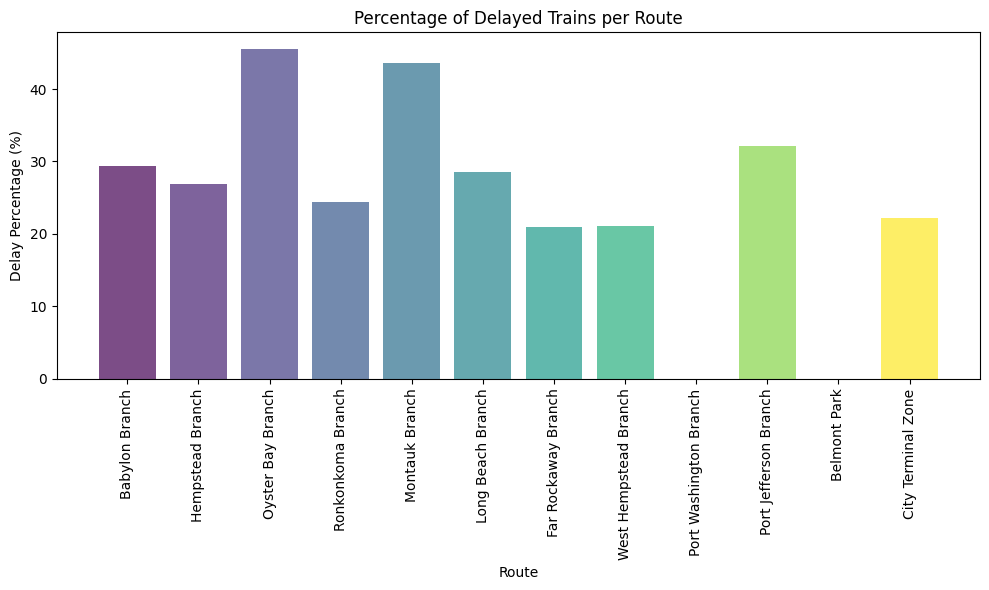

In [17]:
import matplotlib.pyplot as plt

route_names = []
train_counts = []
delayed_train_counts = []
delay_percentages = []

for index, elem in enumerate(route_array):
    route_num = index + 1
    route_name = cur.execute("SELECT route_long_name FROM routes WHERE route_id = ?", (route_num,)).fetchone()[0]
    route_names.append(route_name)
    train_counts.append(elem)

for index, elem in enumerate(delayed_route_array):
    route_num = index + 1
    route_name = cur.execute("SELECT route_long_name FROM routes WHERE route_id = ?", (route_num,)).fetchone()[0]
    delayed_train_counts.append(elem)


for train_count, delayed_train_count in zip(train_counts, delayed_train_counts):
    if train_count != 0:
        delay_percentages.append(delayed_train_count / train_count * 100)
    else:
        delay_percentages.append(0)



num_bars = len(route_names)
colors = plt.cm.viridis(np.linspace(0, 1, num_bars))
plt.figure(figsize=(10, 6))
bars = plt.bar(route_names, delay_percentages, color=colors, alpha=0.7, label='Delay Percentage')
plt.xlabel('Route')
plt.ylabel('Delay Percentage (%)')
plt.title('Percentage of Delayed Trains per Route')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



Counts the number of Westbound (Towards NYC) and Eastbound (Towards Long Island) Trains.

In [18]:
westbound_count = cleaned_data[cleaned_data['direction_id'].astype(int) == 1].shape[0]


eastbound_count = cleaned_data[cleaned_data['direction_id'].astype(int) == 0].shape[0]


print(f"Number of trains Westbound: {westbound_count}")
print(f"Number of trains Eastbound: {eastbound_count}")

Number of trains Westbound: 3392
Number of trains Eastbound: 4799


Counts the number of delayed trains Westbound (Towards NYC) and Eastbound (Towards Long Island) Trains

In [19]:
delayed_trains = cleaned_data[cleaned_data['delay_formatted'] > DELAY]
westbound_delayed_count =delayed_trains[delayed_trains['direction_id'].astype(int) == 1].shape[0]


eastbound_delayed_count = delayed_trains[delayed_trains['direction_id'].astype(int) == 0].shape[0]


print(f"Number of delayed trains Westbound: {westbound_delayed_count}")
print(f"Number of delayed trains Eastbound: {eastbound_delayed_count}")

westbound_delayed_perc = (westbound_delayed_count/westbound_count)*100
eastbound_delayed_perc = (eastbound_delayed_count/eastbound_count)*100
print(  f"Percentage of delayed trains Westbound: {westbound_delayed_perc:.2f}%")
print(  f"Percentage of delayed trains Eastbound: {eastbound_delayed_perc:.2f}%")



Number of delayed trains Westbound: 997
Number of delayed trains Eastbound: 1269
Percentage of delayed trains Westbound: 29.39%
Percentage of delayed trains Eastbound: 26.44%


Counts the total number of trains, and number of delayed trains, and percentage of delayed trains (all trains in the dataset). A Delayed train in this case is any train that arrives more than 1 minute after the scheduled time.

In [24]:

total_trains = cleaned_data.shape[0]
delayed_trains = cleaned_data[cleaned_data['delay_formatted'] > DELAY].shape[0]
percentage_delayed_trains = (delayed_trains / total_trains) * 100
print(f"Total number of trains: {total_trains}")
print(f"Total number of delayed trains: {delayed_trains}")
print(f"Percentage of delayed trains: {percentage_delayed_trains:.2f}%")

Total number of trains: 8191
Total number of delayed trains: 2266
Percentage of delayed trains: 27.66%


Counts the number of trains per hour

In [59]:
delayed_trains_hour = delayed_trains_per_hour(cleaned_data)
print("Delayed trains per hour + percentage")
print(delayed_trains_hour)



Delayed trains per hour + percentage
   hour  delayed_trains_count  total_trains_count  percentage_delayed
0    00                   133                 553           24.050633
1    01                    91                 434           20.967742
2    02                    48                 301           15.946844
3    03                    36                 156           23.076923
4    04                     5                  77            6.493506
5    05                     3                  24           12.500000
6    06                     6                  16           37.500000
7    07                     1                  11            9.090909
8    08                     1                   6           16.666667
9    09                     1                   7           14.285714
10   10                     4                  34           11.764706
11   11                    38                  73           52.054795
12   12                    29                  94    

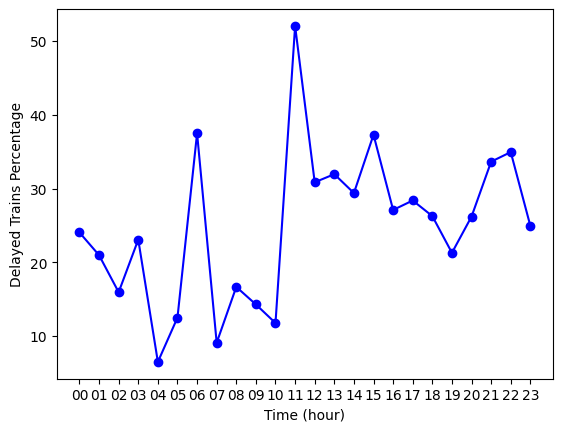

In [62]:

#delayed_trains_hour['delayed_trains_count'].plot(kind='line', figsize=(8, 4), title='Delayed Trains Count')
plt.plot(delayed_trains_hour['hour'], delayed_trains_hour['percentage_delayed'], marker='o', color='b', label='Delayed Trains Percentage')
plt.xticks(range(0, 24))
plt.xlabel('Time (hour)')
plt.ylabel('Delayed Trains Percentage')
plt.show()

Categorize the severity of delays

In general, most delays that are not exceptional delays are usually in the 0-2 min timeframe

In [25]:
#MUST run clean data with option = -1 first
delay_category,category_counts = category_of_delays(cleaned_data)

print(category_counts)

#print(delay_category)

category
> -10 min            22
(-10 to -5 min]     250
(-5 to -2 min]     2345
(-2-0 min]         1733
(0-2 min]          2635
(2-5 min]          1024
(5-10 min]          152
>10+ min             30
Name: count, dtype: int64


<ipython-input-26-66448d612cd8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


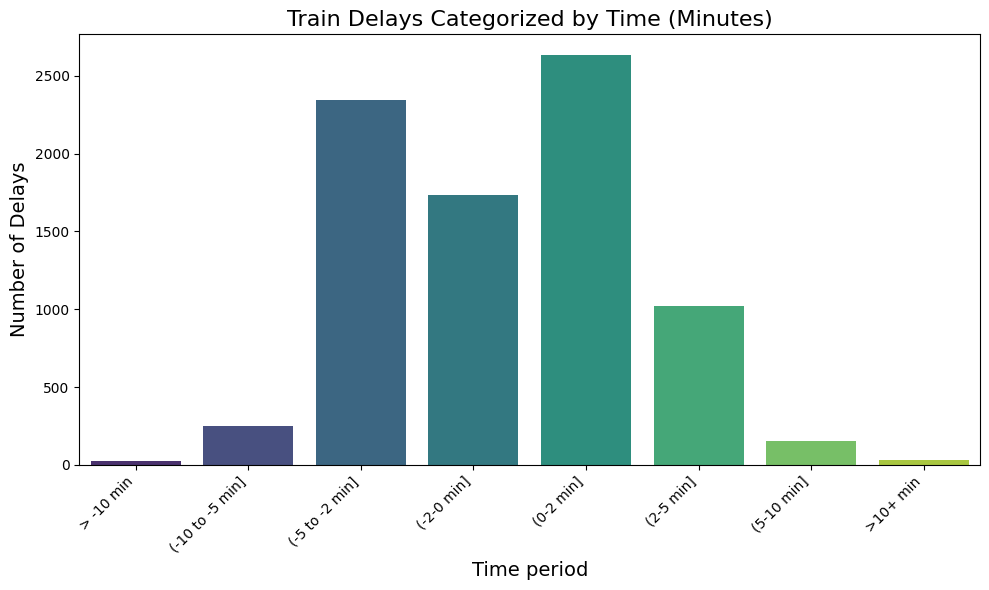

In [26]:
import seaborn
plt.figure(figsize=(10,6))
seaborn.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


plt.title("Train Delays Categorized by Time (Minutes)", fontsize=16)
plt.xlabel("Time period", fontsize=14)
plt.ylabel("Number of Delays", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
cat_delays = category_of_delays(cleaned_data)

#print(cat_delays)

Prints out the number of Peak, AM Peak, PM Peak, Off Peak, and Unknown (either due to missing gtfs update data or due to non-revenue services) trains in the dataset

In [29]:
mod_info_df, res = count_delayed_trains_info(cleaned_data)

AM Peak count: 157
PM Peak count: 1645
Peak count: 1802
Off Peak count: 4413
Unknown count: 1976
Total count: 8191


In [30]:
count_delayed_trains_info_n(mod_info_df, res)

Total delayed trains: 2266
Average delay time (minutes): 2.66
Number of Late trains: 
AM Peak count: 57
PM Peak count: 518
Peak count: 575
Off Peak count: 1261
Unknown count: 430
Total count: 8191

Percentage of trains Late: 
AM Peak percentage: 36.31%
PM Peak percentage: 31.49%
Peak percentage: 31.91%
Off Peak percentage: 28.57%
Unknown percentage: 21.76%


Gets the number of transfers possible in the data. The number of transfers is quite low mainly due to missing gtfs data.

In [31]:
station_id = 102 #JAM
transfer_num = 0
transfers_tot = []

for row in cleaned_data.itertuples():
    trip_id = row.trip_id
    local_arrival_time = row.local_arrival_time
    transfers = get_transfers_trip(cur, station_id, trip_id)
    transfer_num += len(transfers)
    #print(len(transfers))
    transfers_tot += transfers

print(f"Total transfers: {transfer_num}")
#print(transfers)

Total transfers: 1314


Gets number of transfers missed due to very late trains. This is very theoretical, as transfer trains can also be late(!). The calculation is that if a train arrives later than the scheduled departure time of the transfer train or less than 3 minutes before the transfer train is scheduled to depart (as some transfers require going up and over an overpass to another platform), then the transfer is missed.

In [32]:
missed_num = analyze_transfers_trip(cur,station_id, cleaned_data)
print(missed_num)

577


Percentage of theoretical missed transfers.

In [33]:
missed_num/transfer_num * 100

43.9117199391172

In [34]:
duplicates = cleaned_data[cleaned_data.duplicated(subset='trip_id', keep=False)]
duplicate_counts = duplicates.groupby('trip_id').size().reset_index(name='duplicate_count')
duplicate_counts_sorted = duplicate_counts.sort_values(by='duplicate_count', ascending=False)
print(duplicate_counts_sorted)

              trip_id  duplicate_count
200      GO301_24_178               18
435       GO301_24_44               18
5       GO301_24_1068               18
354      GO301_24_276               18
343      GO301_24_274               17
...               ...              ...
717     GO301_24_7616                2
715     GO301_24_7615                2
710   GO301_24_7570_3                2
708   GO301_24_7569_5                2
1220    GO303_24_8976                2

[1221 rows x 2 columns]


Predict the amount of lateness that each train could potentially have, must have more than 8 duplicates in the data to predict successfully.

In [35]:
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Suppress the warning about feature names
warnings.filterwarnings("ignore", message="X does not have valid feature names")

cleaned_data_sorted = cleaned_data.sort_values(by='trip_id')

cleaned_data_sorted['delay_formatted'] = pd.to_numeric(cleaned_data_sorted['delay_formatted'], errors='coerce')
filtered_data_sorted = cleaned_data_sorted.dropna(subset=['delay_formatted'])

features = ['schedule_relationship', 'route_id', 'direction_id']
target = 'delay_formatted'

trip_id_counts = filtered_data_sorted['trip_id'].value_counts()
valid_trip_ids = trip_id_counts[trip_id_counts > 8].index

for trip_id in valid_trip_ids:
    trip_data = filtered_data_sorted[filtered_data_sorted['trip_id'] == trip_id]

    X = trip_data[features]
    y = trip_data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    #print(f'Mean Squared Error for trip_id {trip_id}: {mse}')

    predicted_delays = set()  # Set to track unique predictions
    for index, row in X_test.iterrows():
        predicted_delay = model.predict(row[features].values.reshape(1, -1))
        predicted_delay_in_minutes = predicted_delay[0] / 60

        # Only print if it's a new predicted delay
        if predicted_delay_in_minutes not in predicted_delays:
            predicted_delays.add(predicted_delay_in_minutes)
            print(f'Trip {trip_id} predicted delay: {predicted_delay_in_minutes} minutes')


Trip GO301_24_1068 predicted delay: 0.6059523809523809 minutes
Trip GO301_24_44 predicted delay: -0.6297619047619047 minutes
Trip GO301_24_178 predicted delay: -1.9333333333333333 minutes
Trip GO301_24_276 predicted delay: 0.6761904761904761 minutes
Trip GO301_24_869 predicted delay: -0.4217948717948718 minutes
Trip GO301_24_274 predicted delay: 0.0038461538461538464 minutes
Trip GO301_24_179 predicted delay: -0.3875 minutes
Trip GO301_24_1574 predicted delay: -3.0208333333333335 minutes
Trip GO301_24_566 predicted delay: 1.1222222222222222 minutes
Trip GO301_24_181 predicted delay: -1.425 minutes
Trip GO301_24_2768 predicted delay: 2.0791666666666666 minutes
Trip GO301_24_267 predicted delay: -0.3541666666666667 minutes
Trip GO301_24_568 predicted delay: 2.3847222222222224 minutes
Trip GO301_24_175 predicted delay: 0.7708333333333334 minutes
Trip GO301_24_772 predicted delay: 1.9791666666666667 minutes
Trip GO301_24_1570 predicted delay: 0.45416666666666666 minutes
Trip GO301_24_174 p

Closes the connection

In [ ]:
#con.close()